In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import OrderedDict
import pickle
import pickle5
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import auc, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.utils import resample
from pysurvival.models.semi_parametric import CoxPHModel
from lifelines.utils import concordance_index
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score,classification_report, f1_score
from sklearn.metrics import plot_confusion_matrix

## block warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("../data/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
3,5871.5,2018-02-06 15:27:00,2018-02-10 17:18:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,1,Tuesday,15,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
4,1454.5,2018-02-10 18:26:00,2018-02-11 18:40:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,5,Saturday,18,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


### Remove outliers & nan

In [ ]:
# remove rows
df = df.dropna()

In [7]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [8]:
df.shape

(12075, 71)

### Usefull functions

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [10]:
## To test model
def test_model(y_test, y_pred):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    NRMSE = RMSE/np.mean(y_test)
    return MAE, RMSE, MSE, MAPE, NRMSE

In [11]:
## Get point predictions
def point_pred(model, X_test, X_train):
    T_pred = []
    T_pred_train = []
    # Get survival curves
    cph_pred = model.predict_survival(X_test)
    cph_pred_train = model.predict_survival(X_train)
    # get times of survival prediction
    time = model.times
    # test
    for i in range(0,len(cph_pred)):
        T_pred.append(auc(time,cph_pred[i]))
    # train
    for i in range(0,len(cph_pred_train)):
        T_pred_train.append(auc(time,cph_pred_train[i]))
    
    return T_pred, T_pred_train

In [12]:
## Get point predictions
def point_pred_single(model, X_test):
    T_pred = []
    # Get survival curves
    cph_pred = model.predict_survival(X_test)
    # get times of survival prediction
    time = model.times
    # test
    for i in range(0,len(cph_pred)):
        T_pred.append(auc(time,cph_pred[i]))
    
    return T_pred

In [13]:
# function to evaluate only accuracy, precision, recall and f1 score
def evaluate_scores(y_true, y_pred):
    # calculate confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", round(accuracy,2))
    print("precision:", round(precision,2))
    print("recall:", round(recall,2))
    print("f1 score:", round(f1,2))
    return accuracy, precision, recall, f1

### Prepare data

In [14]:
def hour_label(X):
    if (X >= 7) & (X <= 10):
        return 'Morning'
    elif (X >= 11) & (X <= 14):
        return 'Midday'
    elif (X >= 15) & (X <= 18):
        return 'Afternoon'
    elif (X >= 19) or (X < 1):
        return 'Evening'
    elif (X >= 1) & (X <= 6):
        return 'Night'

In [15]:
## Add time of day and day of week
df['tod'] = df['hour_b'].apply(hour_label)

In [16]:
df = df[df['tod'] != 'Night']

In [17]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']
single_stat = 'COMM VITALITY / 1400 WALNUT1'
df4 = df[df['Station_Name'].isin(station_subset)]
dfSingle  = df[df['Station_Name'] == single_stat]

In [18]:
print("Shape df 4 station:", df4.shape)
print("Shape of single1:", dfSingle.shape)

Shape df 4 station: (5110, 72)
Shape of single1: (481, 72)
Shape of single2: (297, 72)


In [19]:
np.mean(dfSingle['life_time'])

1278.52079002079

Add dummy variables

In [108]:
dfSingle_orig = dfSingle

In [109]:
# Categorical features
columns_categorical = ['weekday_b_name','tod','Station_Name']
df4 = pd.get_dummies(df4, columns=columns_categorical)
columns_categorical = ['weekday_b_name','tod']
dfSingle = pd.get_dummies(dfSingle, columns=columns_categorical)
dfSingle2 = pd.get_dummies(dfSingle2, columns=columns_categorical)

Sort dataframes

In [110]:
df4 = df4.sort_values(by=['datetime_start'])
dfSingle = dfSingle.sort_values(by=['datetime_start'])

M4 is used as the name for the Full features constellation throughout the notebook.

In [111]:
features4_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']

features4_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education', 'waste-management']  # dow + agg. tod + lag + activ.

Split data

In [112]:
split = 0.8
train4, test4 = np.split(df4, [int(split * len(df4))])

In [114]:
split = 0.8

## Get X and y - M5
X = train4[features4_cat+features4_con]
y = train4['life_time']

## split data
X_train4, X_test4 = np.split(X, [int(split * len(X))])
y_train4, y_test4 = np.split(y, [int(split * len(X))])

## Standardize
scaler = StandardScaler()
X_train4[features4_con] = scaler.fit_transform(X_train4[features4_con])
X_test4[features4_con] = scaler.transform(X_test4[features4_con])

Prepare the single dataframe:

In [116]:
stat_cols = ['Station_Name_BOULDER / N BOULDER REC 1',
             'Station_Name_COMM VITALITY / 1000WALNUT',
             'Station_Name_COMM VITALITY / 1104 SPRUCE1']
for col in stat_cols:
    dfSingle[col] = np.zeros(len(dfSingle))

In [117]:
y_single = dfSingle['life_time']
X_single = dfSingle[features4_cat + features4_con]
scaler = StandardScaler()
X_single[features4_con] = scaler.fit_transform(X_single[features4_con])

As it is closest to 1000 WALNUT this features is activated

In [118]:
X_single['Station_Name_COMM VITALITY / 1000WALNUT'] = np.ones(len(X_single))

## ML methods

Specify hyper parameters

In [119]:
params = {}
params['M1'] = {}
params['M4'] = {}
params['M1']['LR'] = {'alpha':15}
params['M4']['LR'] = {'alpha':15}
params['M1']['RF'] = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': 7}
params['M4']['RF'] = {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_depth': 7}
params['M1']['MLP'] = {'hidden_layer_sizes': (128, 128, 128, 128), 'alpha': 0.001, 'activation': 'relu'}
params['M4']['MLP'] = {'hidden_layer_sizes': 256, 'alpha': 0.001, 'activation': 'relu'}
params['M1']['GB'] = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.5}
params['M4']['GB'] = {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.01}

**Linear regression**

In [120]:
param = params['M4']['LR']
reg_LR = Ridge(random_state=42, alpha=param['alpha'])
reg_LR.fit(X_train4,y_train4)

Ridge(alpha=15, random_state=42)

In [121]:
pred = reg_LR.predict(X_single)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_single,pred)
r_squarred = r2_score(y_single,pred)
print("R2: {} RMSE: {} MAE: {} MAPE: {}".format(round(r_squarred,2), round(RMSE,0),
                                                round(MAE,0), round(MAPE,0)))

R2: -0.76 RMSE: 1387.0 MAE: 1005.0 MAPE: 428.0


**Random forest**

In [122]:
param = params['M4']['RF']
reg_RF = RandomForestRegressor(random_state=42, 
                            min_samples_split=param['min_samples_split'],
                            min_samples_leaf=param['min_samples_leaf'],
                            max_depth=param['max_depth'],
                            n_estimators=param['n_estimators'])    
reg_RF.fit(X_train4, y_train4) 

RandomForestRegressor(max_depth=7, min_samples_leaf=10, min_samples_split=3,
                      n_estimators=500, random_state=42)

In [123]:
pred = reg_RF.predict(X_single)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_single,pred)
r_squarred = r2_score(y_single,pred)
print("R2: {} RMSE: {} MAE: {} MAPE: {}".format(round(r_squarred,2), round(RMSE,0),
                                                round(MAE,0), round(MAPE,0)))

R2: -0.76 RMSE: 1389.0 MAE: 1024.0 MAPE: 417.0


**Gradient boosting**

In [124]:
param = params['M4']['GB']
reg1 = GradientBoostingRegressor(random_state=42, 
                                max_depth=param['max_depth'],
                                min_samples_split=param['min_samples_split'],
                                min_samples_leaf=param['min_samples_leaf'],
                                n_estimators=param['n_estimators'], 
                                learning_rate=param['learning_rate'])
reg1.fit(X_train4, y_train4)

GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=5,
                          min_samples_split=5, n_estimators=500,
                          random_state=42)

In [125]:
pred = reg1.predict(X_single)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_single,pred)
r_squarred = r2_score(y_single,pred)
print("R2: {} RMSE: {} MAE: {} MAPE: {}".format(round(r_squarred,2), round(RMSE,0),
                                                round(MAE,0), round(MAPE,0)))

R2: -0.73 RMSE: 1376.0 MAE: 1008.0 MAPE: 383.0


**MLP**

In [126]:
param = params['M4']['MLP']
reg_MLP = MLPRegressor(random_state=42, alpha=param['alpha'], 
                   hidden_layer_sizes=param['hidden_layer_sizes'],
                   activation = param['activation'],
                   max_iter=500, early_stopping=True)
reg_MLP.fit(X_train4, y_train4)

MLPRegressor(alpha=0.001, early_stopping=True, hidden_layer_sizes=256,
             max_iter=500, random_state=42)

In [127]:
pred = reg_MLP.predict(X_single)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_single,pred)
r_squarred = r2_score(y_single,pred)
print("R2: {} RMSE: {} MAE: {} MAPE: {}".format(round(r_squarred,2), round(RMSE,0),
                                                round(MAE,0), round(MAPE,0)))

R2: -1.16 RMSE: 1538.0 MAE: 1146.0 MAPE: 251.0


## Quantile regression

In [128]:
quantile_labels = ['5%','25%','50%','75%','95%']
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
qr_M4 = pd.DataFrame(columns=quantile_labels)
qr_M4['true'] = y_single.values

In [129]:
for i in range(len(quantiles)):
    regGB = GradientBoostingRegressor(random_state=42, max_depth=3,
                                        n_estimators=500, 
                                        learning_rate=0.01,
                                        min_samples_split=5,
                                        min_samples_leaf=5,
                                        loss='quantile', alpha=quantiles[i])
    regGB.fit(X_train4,y_train4)
    qr_M4[quantile_labels[i]] = regGB.predict(X_single)

In [130]:
qr_M4['tod'] = dfSingle_orig['tod'].values

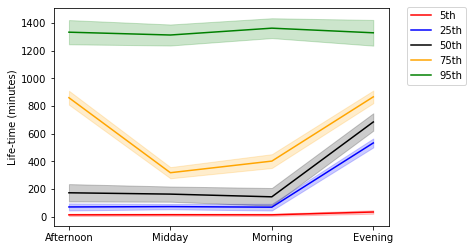

In [131]:
tods = ['Afternoon', 'Midday', 'Morning', 'Evening']

## Get mean and standard deviation of each quantile and TOD combination
results_mean = pd.DataFrame(columns=quantile_labels, index=tods)
results_std = pd.DataFrame(columns=quantile_labels, index=tods)
for t in tods:
    temp = qr_M4[qr_M4['tod'] == t]
    for q in quantile_labels:
        temp2 = temp[q]
        results_mean.loc[t][q] = np.mean(temp2.values)
        results_std.loc[t][q] = np.std(temp2.values)
        
colors = ['red','blue','black','orange','green']

for i in range(len(quantile_labels)):
    q = quantile_labels[i] # get the quantile label
    lower = list((results_mean[q] - results_std[q]*2))
    upper = list((results_mean[q] + results_std[q]*2))
    plt.fill_between(x=tods, y1=lower, y2=upper, alpha=0.2, color=colors[i])
    plt.plot(results_mean[q], color=colors[i], label=q)
    
plt.legend(bbox_to_anchor=(1.04,1.03), loc="upper left")
plt.ylabel("Life-time (minutes)")
#plt.title("Quantiles for the life-time as a function of the time-of-day")
#plt.savefig('../Thesis - writing/Visualization/QR_TOD.pdf',bbox_inches='tight')
plt.show()

Get the summary statistics.

In [132]:
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_single,qr_M4['50th'])
r_squarred = r2_score(y_single,qr_M4['50th'])
print("R2: {} RMSE: {} MAE: {} MAPE: {}".format(round(r_squarred,2), round(RMSE,0),
                                                round(MAE,0), round(MAPE,0)))

R2: -1.03 RMSE: 1491.0 MAE: 1106.0 MAPE: 163.0


In [133]:
def ICP(q1, q2, true):
    if (true >= q1) and (true <= q2):
        return 1
    else:
        return 0

In [134]:
#### 5%-95%
qr_M4['MIL5-95'] = qr_M4['95th']-qr_M4['5th']
qr_M4 = qr_M4.reset_index()
# Get ICP
temp = []
for i in range(len(y_single)):
    row = qr_M4.loc[i]
    temp.append(ICP(row['5th'], row['95th'], row['true']))
qr_M4['ICP5-95'] = temp


#### 25%-75%
## M5
qr_M4['MIL25-75'] = qr_M4['75th']-qr_M4['25th']
# Get ICP
temp = []
for i in range(len(y_single)):
    row = qr_M4.loc[i]
    temp.append(ICP(row['25th'], row['75th'], row['true']))
qr_M4['ICP25-75'] = temp


In [135]:
print("Full (5%-95%): MIL: {} ICP: {}".format(round(np.mean(qr_M4['MIL5-95']),2), 
                                            round(np.sum(qr_M4['ICP5-95'])/len(qr_M4),3)))
print("Full (25%-75%): MIL: {} ICP: {}".format(round(np.mean(qr_M4['MIL25-75']),2), 
                                            round(np.sum(qr_M4['ICP25-75'])/len(qr_M4),3)))

Full (5%-95%): MIL: 1313.85 ICP: 0.632
Full (25%-75%): MIL: 441.7 ICP: 0.191


### Survival analysis

Split the data for survival analysis

In [136]:
X_train = df4[features4_cat+features4_con]
T_train = df4['life_time']
E_train = np.ones(len(df4))

reg = CoxPHModel()
reg.fit(X_train, T_train, E_train, lr= 0.01, l2_reg=0.1, init_method='zeros', max_iter=800, verbose=False)

CoxPHModel

In [137]:
surv = reg.predict_survival(x=X_single)
time = reg.times

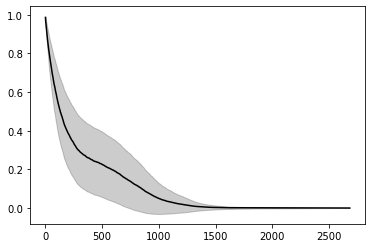

In [138]:
mean = []
upper = []
lower = []

N = 2

for k in range(len(time)):
    vals = surv[:,k]
    mean.append(np.mean(vals))
    std_ = np.std(vals)
    upper.append(np.mean(vals)+std_*N)
    lower.append(np.mean(vals)-std_*N)
    
plt.fill_between(x=time, y1=lower, y2=upper, alpha=0.2, color='k')
plt.plot(time,mean, color='k')
plt.show()

In [139]:
dfSingle_orig = dfSingle_orig.reset_index()

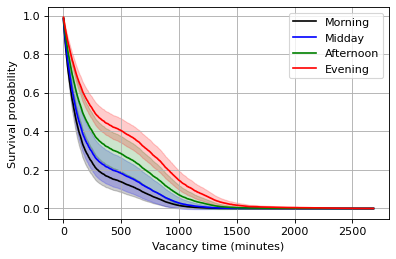

In [140]:
from matplotlib.pyplot import figure

figure(figsize=(5.5, 3.5), dpi=80)

mean = {}
upper = {}
lower = {}

#temp = df_new[features4_cat+features4_con]
tod = ['Morning', 'Midday', 'Afternoon', 'Evening']

N = 2

for t in tod:
    idx = dfSingle_orig[dfSingle_orig['tod'] == t].index
    temp_surv = surv[idx]
    
    temp_mean = []
    temp_upper = []
    temp_lower = []
    for k in range(len(time)):
        vals = temp_surv[:,k]
        temp_mean.append(np.mean(vals))
        std_ = np.std(vals)
        temp_upper.append(np.mean(vals)+std_*N)
        temp_lower.append(np.mean(vals)-std_*N)
        
    mean[t] = temp_mean
    lower[t] = temp_lower
    upper[t] = temp_upper
#     axs[i,j]
#     axs[i,j].fill_between(x=time, y1=lower, y2=upper, alpha=0.2, color='k')
#     axs[i,j].plot(time,mean, color='k')

tod_color = ['k','b','g','r']
tod_label = ['Morning','Midday','Afternoon','Evening']
for i in range(len(tod)):
    plt.plot(time,mean[tod[i]], color=tod_color[i], label=tod_label[i])
    plt.fill_between(x=time, y1=lower[tod[i]], y2=upper[tod[i]], color=tod_color[i],alpha=0.2)
plt.grid()
plt.xlabel("Vacancy time (minutes)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

Point estimates predictions

In [141]:
point_predictions = point_pred_single(reg,X_single)

In [142]:
c_idx = concordance_index(y_single, point_predictions)

In [143]:
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_single,point_predictions)
r_squarred = r2_score(y_single,point_predictions)
print("R2: {} C-index: {} RMSE: {} MAE: {} MAPE: {}".format(round(r_squarred,2), round(c_idx,2),
                                                            round(RMSE,0), round(MAE,0),
                                                            round(MAPE,0)))

R2: -0.89 C-index: 0.52 RMSE: 1436.0 MAE: 1060.0 MAPE: 377.0


# Two-Step - predict for different station

Classify single station

In [144]:
def hsplit(X):
    if X >= 4*60:
        return 1
    else:
        return 0

In [145]:
y_train4C = y_train4.apply(hsplit)

In [146]:
### Train classifier
# Evaluate model
clf = GradientBoostingClassifier(random_state=42, 
                                max_depth=3,
                                min_samples_split=5,
                                min_samples_leaf=3,
                                n_estimators=500, 
                                learning_rate=0.01)
clf.fit(X_train4,y_train4C)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=3,
                           min_samples_split=5, n_estimators=500,
                           random_state=42)

In [147]:
preds = clf.predict(X_single)
dfSingle['pred_class'] = preds
short_idx = dfSingle[dfSingle['pred_class'] == 0].index
long_idx = dfSingle[dfSingle['pred_class'] == 1].index

In [148]:
X_singleS = X_single.loc[short_idx]
X_singleL = X_single.loc[long_idx]
y_singleS = y_single.loc[short_idx]
y_singleL = y_single.loc[long_idx]

In [149]:
dfSingle['real_class'] = dfSingle['life_time'].apply(hsplit)

In [150]:
print("Predicted: SHORT: {} LONG: {}".format(len(X_singleS),len(X_singleL)))
print("Real: SHORT {} LONG: {}".format(len(dfSingle[dfSingle['real_class']==0]),
                                       len(dfSingle[dfSingle['real_class']==1])))

Predicted: SHORT: 441 LONG: 40
Real: SHORT 105 LONG: 376


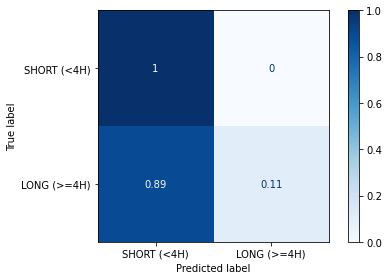

In [151]:
class_names = ['SHORT (<4H)','LONG (>=4H)']
plot_confusion_matrix(clf, X_single, dfSingle['real_class'], cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.tight_layout()
plt.show()

In [152]:
accuracy, precision, recall, f1 = evaluate_scores(dfSingle['real_class'],dfSingle['pred_class'])
results_qr = {'f1':f1, 'accuracy':accuracy, 'precision':precision, 'recall':recall}
results_qr

accuracy: 0.3
precision: 1.0
recall: 0.11
f1 score: 0.19


{'f1': 0.1923076923076923,
 'accuracy': 0.30145530145530147,
 'precision': 1.0,
 'recall': 0.10638297872340426}

Load classified 4 station data:

In [153]:
# under_utilization data
with open("../data/ut_V6_classification-4H.pkl", "rb") as fh:
    dfC = pickle5.load(fh)
    
dfC.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,weekday_b,charging_ports,lag1,lag2,...,hour_b_22,hour_b_23,Station_Name_BOULDER / N BOULDER REC 1,Station_Name_COMM VITALITY / 1000WALNUT,Station_Name_COMM VITALITY / 1104 SPRUCE1,4Hsplit,y_pred,Station_Name,weekday_b_name,tod
3734,118.5,2018-01-05 14:25:00,2018-01-05 16:23:30,40.000148,-105.282437,2.096847,4,2,1271.5,135.5,...,0,0,0,0,0,0,1,BOULDER / BASELINE ST1,Friday,Midday
3735,886.5,2018-01-05 17:02:00,2018-01-06 07:48:30,40.000148,-105.282437,2.096847,4,2,118.5,1271.5,...,0,0,0,0,0,1,1,BOULDER / BASELINE ST1,Friday,Afternoon
3736,326.5,2018-01-06 09:28:00,2018-01-06 14:54:30,40.000148,-105.282437,2.096847,5,2,886.5,118.5,...,0,0,0,0,0,1,0,BOULDER / BASELINE ST1,Saturday,Morning
3737,996.5,2018-01-06 17:09:00,2018-01-07 09:45:30,40.000148,-105.282437,2.096847,5,2,326.5,886.5,...,0,0,0,0,0,1,1,BOULDER / BASELINE ST1,Saturday,Afternoon
3738,52.5,2018-01-07 10:58:00,2018-01-07 11:50:30,40.000148,-105.282437,2.096847,6,2,996.5,326.5,...,0,0,0,0,0,0,0,BOULDER / BASELINE ST1,Sunday,Morning


In [154]:
dfC.groupby(['y_pred']).count().life_time

y_pred
0    3062
1    2048
Name: life_time, dtype: int64

In [155]:
train, test = np.split(dfC, [int(split * len(dfC))])
print("Training shape:",train.shape)
print("Testing shape:", test.shape)

trainS = train[train['y_pred'] == 0]
trainL = train[train['y_pred'] == 1]

testS = test[test['y_pred'] == 0]
testL = test[test['y_pred'] == 1]

print("SHORT: Train: {} Test: {}".format(trainS.shape[0], testS.shape[0]))
print("LONG: Train: {} Test: {}".format(trainL.shape[0], testL.shape[0]))

Training shape: (4088, 102)
Testing shape: (1022, 102)
SHORT: Train: 2433 Test: 629
LONG: Train: 1655 Test: 393


In [156]:
# Full
X_S = trainS[features4_cat+features4_con]
scaler = StandardScaler()
X_S[features4_con] = scaler.fit_transform(X_S[features4_con])
X_L = trainL[features4_cat+features4_con]
scaler = StandardScaler()
X_L[features4_con] = scaler.fit_transform(X_L[features4_con])

## Get y - train
y_S = trainS['life_time']
y_L = trainL['life_time']

## Two-step approach, machine learning methods

In [157]:
results_ML = {}

Define parameters:

In [158]:
parameters = {}
parameters['LR'] = {}
parameters['LR']['S'] = {'alpha':20}
parameters['LR']['L'] = {'alpha':20}
parameters['RF'] = {}
parameters['RF']['S'] = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': 7}
parameters['RF']['L'] = {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_depth': 3}
parameters['GB'] = {}
parameters['GB']['S'] = {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.01}
parameters['GB']['L'] = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 2, 'learning_rate': 0.01}
parameters['MLP'] = {}
parameters['MLP']['S'] = {'hidden_layer_sizes': 256, 'alpha': 10, 'activation': 'relu'}
parameters['MLP']['L'] = {'hidden_layer_sizes': (32, 32), 'alpha': 0.0001, 'activation': 'relu'}

In [159]:
## LR
results_ML['LR'] = {}

paramS = parameters['LR']['S']
paramL = parameters['LR']['L']

regs = Ridge(random_state=42, alpha=paramS['alpha'], fit_intercept=False)
regs.fit(X_S,y_S)
regl = Ridge(random_state=42, alpha=paramL['alpha'], fit_intercept=False)
regl.fit(X_L,y_L)

y_test_predS = regs.predict(X_singleS)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleS,y_test_predS)
## Save results
results_ML['LR']['S'] = {'rsq':r2_score(y_singleS, y_test_predS),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}
y_test_predL = regl.predict(X_singleL)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleL,y_test_predL)
## Save results
results_ML['LR']['L'] = {'rsq':r2_score(y_singleL, y_test_predL),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}

## COMBINED
y_combined_pred = np.concatenate([y_test_predS,y_test_predL])
y_combined_real = pd.concat([y_singleS,y_singleL])
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_combined_real,y_combined_pred)
results_ML['LR']['Com'] = {'rsq':r2_score(y_singleL, y_test_predL),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}


In [160]:
## RF
results_ML['RF'] = {}

paramS = parameters['RF']['S']
paramL = parameters['RF']['L']

regs = RandomForestRegressor(random_state=42, 
                            min_samples_split=paramS['min_samples_split'],
                            min_samples_leaf=paramS['min_samples_leaf'],
                            max_depth=paramS['max_depth'],
                            n_estimators=paramS['n_estimators'])
regs.fit(X_S,y_S)
regl = RandomForestRegressor(random_state=42, 
                            min_samples_split=paramL['min_samples_split'],
                            min_samples_leaf=paramL['min_samples_leaf'], 
                            max_depth=paramL['max_depth'],
                            n_estimators=paramL['n_estimators'])
regl.fit(X_L,y_L)

y_test_predS = regs.predict(X_singleS)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleS,y_test_predS)
## Save results
results_ML['RF']['S'] = {'rsq':r2_score(y_singleS, y_test_predS),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}
y_test_predL = regl.predict(X_singleL)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleL,y_test_predL)
## Save results
results_ML['RF']['L'] = {'rsq':r2_score(y_singleL, y_test_predL),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}

## COMBINED
y_combined_pred = np.concatenate([y_test_predS,y_test_predL])
y_combined_real = pd.concat([y_singleS,y_singleL])
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_combined_real,y_combined_pred)
results_ML['RF']['Com'] = {'rsq':r2_score(y_singleL, y_test_predL),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}


In [161]:
## RF
results_ML['MLP'] = {}

paramS = parameters['MLP']['S']
paramL = parameters['MLP']['L']

regs = MLPRegressor(random_state=42, alpha=paramS['alpha'], 
                    hidden_layer_sizes=paramS['hidden_layer_sizes'],
                    max_iter=500, early_stopping=True)
regs.fit(X_S,y_S)
regl = MLPRegressor(random_state=42, alpha=paramS['alpha'], 
                    hidden_layer_sizes=paramS['hidden_layer_sizes'],
                    max_iter=500, early_stopping=True)
regl.fit(X_L,y_L)

y_test_predS = regs.predict(X_singleS)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleS,y_test_predS)
## Save results
results_ML['MLP']['S'] = {'rsq':r2_score(y_singleS, y_test_predS),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}
y_test_predL = regl.predict(X_singleL)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleL,y_test_predL)
## Save results
results_ML['MLP']['L'] = {'rsq':r2_score(y_singleL, y_test_predL),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}

## COMBINED
y_combined_pred = np.concatenate([y_test_predS,y_test_predL])
y_combined_real = pd.concat([y_singleS,y_singleL])
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_combined_real,y_combined_pred)
results_ML['MLP']['Com'] = {'rsq':r2_score(y_singleL, y_test_predL),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}


In [162]:
## RF
results_ML['GB'] = {}

paramS = parameters['GB']['S']
paramL = parameters['GB']['L']

regs = GradientBoostingRegressor(random_state=42, 
                                max_depth=paramS['max_depth'],
                                n_estimators=paramS['n_estimators'], 
                                learning_rate=paramS['learning_rate'])
regs.fit(X_S,y_S)
regl = GradientBoostingRegressor(random_state=42, 
                                max_depth=paramL['max_depth'],
                                n_estimators=paramL['n_estimators'], 
                                learning_rate=paramL['learning_rate'])
regl.fit(X_L,y_L)

y_test_predS = regs.predict(X_singleS)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleS,y_test_predS)
## Save results
results_ML['GB']['S'] = {'rsq':r2_score(y_singleS, y_test_predS),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}
y_test_predL = regl.predict(X_singleL)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleL,y_test_predL)
## Save results
results_ML['GB']['L'] = {'rsq':r2_score(y_singleL, y_test_predL),
                         'RMSE':RMSE, 'MAE':MAE,
                              'MAPE':MAPE,'NRMSE_train':NRMSE}

## COMBINED
y_combined_pred = np.concatenate([y_test_predS,y_test_predL])
y_combined_real = pd.concat([y_singleS,y_singleL])
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_combined_real,y_combined_pred)
results_ML['GB']['Com'] = {'rsq':r2_score(y_combined_real, y_combined_pred),
                           'RMSE':RMSE, 'MAE':MAE,
                           'MAPE':MAPE,'NRMSE_train':NRMSE}

In [163]:
methods = ['LR', 'RF', 'MLP', 'GB']

print(20*'-',"COMBINED",20*'-')
for me in methods:
    r = results_ML[me]['Com']
    RMSE = r['RMSE']
    R2 = r['rsq']
    MAE = r['MAE']
    MAPE = r['MAPE']
    #NRMSE = r['NRMSE']
    print("{}:  R2: {} RMSE: {} MAE: {} MAPE: {}".format(me,
                                                                  round(np.mean(R2),2),
                                                                  round(np.mean(RMSE),0),
                                                                  round(np.mean(MAE),0),
                                                                  round(np.mean(MAPE),0)))        
print("\n")

-------------------- COMBINED --------------------
LR:  R2: -0.72 RMSE: 1432.0 MAE: 1051.0 MAPE: 309.0
RF:  R2: -0.95 RMSE: 1407.0 MAE: 1036.0 MAPE: 358.0
MLP:  R2: -2.15 RMSE: 1553.0 MAE: 1167.0 MAPE: 177.0
GB:  R2: -0.77 RMSE: 1390.0 MAE: 1022.0 MAPE: 316.0




## Two-step approach, quantile regression

In [164]:
quantile_labels = ['5th','25th','50th','75th','95th']
# M4 - Full
qr_M4_S = pd.DataFrame(columns=quantile_labels+['true'])
qr_M4_S['true'] = y_singleS
qr_M4_L = pd.DataFrame(columns=quantile_labels+['true'])
qr_M4_L['true'] = y_singleL

In [165]:
## SHORT
for i in range(len(quantiles)):
    print("SHORT, Q: {}".format(quantiles[i]))
    reg = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=300,
                                    min_samples_split=5,
                                    min_samples_leaf=15,
                                    learning_rate=0.01,
                                    loss='quantile', alpha=quantiles[i])
    reg.fit(X_S,y_S)
    qr_M4_S[quantile_labels[i]] = reg.predict(X_singleS)
    
## LONG
for i in range(len(quantiles)):
    print("LONG, Q: {}".format(quantiles[i]))
    reg = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=300,
                                    min_samples_split=5,
                                    min_samples_leaf=15,
                                    learning_rate=0.01,
                                    loss='quantile', alpha=quantiles[i])
    reg.fit(X_L,y_L)
    qr_M4_L[quantile_labels[i]] = reg.predict(X_singleL)
    

SHORT, Q: 0.05
SHORT, Q: 0.25
SHORT, Q: 0.5
SHORT, Q: 0.75
SHORT, Q: 0.95
LONG, Q: 0.05
LONG, Q: 0.25
LONG, Q: 0.5
LONG, Q: 0.75
LONG, Q: 0.95


In [166]:
M4_pred_com = qr_M4_S.append(qr_M4_L)

In [167]:
results_QR = {}

## Get metrics
MAE_test, RMSE_test, MSE_test, MAPE_test, NRMSE_test = test_model(qr_M4_S['true'],qr_M4_S['50th'])
results_QR['S'] = {'RMSE_test':RMSE_test,'MAE_test':MAE_test,
                      'rsq_test':r2_score(qr_M4_S['true'],qr_M4_S['50th']),
                      'MAPE_test':MAPE_test,'NRMSE_test':NRMSE_test}

MAE_test, RMSE_test, MSE_test, MAPE_test, NRMSE_test = test_model(qr_M4_L['true'],qr_M4_L['50th'])
results_QR['L'] = {'RMSE_test':RMSE_test,'MAE_test':MAE_test,
                      'rsq_test':r2_score(qr_M4_L['true'],qr_M4_L['50th']),
                      'MAPE_test':MAPE_test,'NRMSE_test':NRMSE_test}

MAE_test, RMSE_test, MSE_test, MAPE_test, NRMSE_test = test_model(M4_pred_com['true'],M4_pred_com['50th'])
results_QR['Com'] = {'RMSE_test':RMSE_test,'MAE_test':MAE_test,
                      'rsq_test':r2_score(M4_pred_com['true'],M4_pred_com['50th']),
                      'MAPE_test':MAPE_test,'NRMSE_test':NRMSE_test}

In [168]:
results_QR

{'S': {'RMSE_test': 1507.8978567069241,
  'MAE_test': 1119.6401809937265,
  'rsq_test': -1.0874781371053093,
  'MAPE_test': 181.15820674156268,
  'NRMSE_test': 1.2186305994217377},
 'L': {'RMSE_test': 1331.694924828998,
  'MAE_test': 946.3878688541057,
  'rsq_test': -0.923348380791938,
  'MAPE_test': 40.07370494703027,
  'NRMSE_test': 0.7687882027646911},
 'Com': {'RMSE_test': 1494.0372317733145,
  'MAE_test': 1105.232504308519,
  'rsq_test': -1.0403520615265514,
  'MAPE_test': 169.42560783973047,
  'NRMSE_test': 1.1685670216978012}}

In [169]:
######### M5 #########
####### SHORT #######
## 5%-95%
qr_M4_S['MIL5-95'] = qr_M4_S['95th']-qr_M4_S['5th']
qr_M4_S = qr_M4_S.reset_index()
# Get ICP
temp = []
for i in range(len(y_singleS)):
    row = qr_M4_S.loc[i]
    temp.append(ICP(row['5th'], row['95th'], row['true']))
qr_M4_S['ICP5-95'] = temp

## 25%-75%
qr_M4_S['MIL25-75'] = qr_M4_S['75th']-qr_M4_S['25th']
# Get ICP
temp = []
for i in range(len(y_singleS)):
    row = qr_M4_S.loc[i]
    temp.append(ICP(row['25th'], row['75th'], row['true']))
qr_M4_S['ICP25-75'] = temp

####### LONG #######
## 5%-95%
qr_M4_L['MIL5-95'] = qr_M4_L['95th']-qr_M4_L['5th']
qr_M4_L = qr_M4_L.reset_index()
# Get ICP
temp = []
for i in range(len(y_singleL)):
    row = qr_M4_L.loc[i]
    temp.append(ICP(row['5th'], row['95th'], row['true']))
qr_M4_L['ICP5-95'] = temp

## 25%-75%
qr_M4_L['MIL25-75'] = qr_M4_L['75th']-qr_M4_L['25th']
# Get ICP
temp = []
for i in range(len(y_singleL)):
    row = qr_M4_L.loc[i]
    temp.append(ICP(row['25th'], row['75th'], row['true']))
qr_M4_L['ICP25-75'] = temp

####### COMBINED #######
## 5%-95%
M4_pred_com['MIL5-95'] = M4_pred_com['95th']-M4_pred_com['5th']
M4_pred_com = M4_pred_com.reset_index()
# Get ICP
temp = []
for i in range(len(M4_pred_com)):
    row = M4_pred_com.loc[i]
    temp.append(ICP(row['5th'], row['95th'], row['true']))
M4_pred_com['ICP5-95'] = temp

## 25%-75%
M4_pred_com['MIL25-75'] = M4_pred_com['75th']-M4_pred_com['25th']
# Get ICP
temp = []
for i in range(len(M4_pred_com)):
    row = M4_pred_com.loc[i]
    temp.append(ICP(row['25th'], row['75th'], row['true']))
M4_pred_com['ICP25-75'] = temp


In [170]:
qr_M4_S = qr_M4_S.set_index('index')
qr_M4_L = qr_M4_L.set_index('index')
M4_pred_com = M4_pred_com.set_index('index')

In [171]:
qr_M4_S = qr_M4_S.merge(df[['tod','weekday_b_name','Station_Name']],left_index=True,right_index=True)
qr_M4_L = qr_M4_L.merge(df[['tod','weekday_b_name','Station_Name']],left_index=True,right_index=True)
M4_pred_com = M4_pred_com.merge(df[['tod','weekday_b_name','Station_Name']],left_index=True,right_index=True)

In [172]:
print("------ SHORT ------ ")
print("Full (5%-95%): MIL: {} ICP: {}".format(round(np.mean(qr_M4_S['MIL5-95']),2), 
                                            round(np.sum(qr_M4_S['ICP5-95'])/len(qr_M4_S),3)))
print("Full (25%-75%): MIL: {} ICP: {}".format(round(np.mean(qr_M4_S['MIL25-75']),2), 
                                            round(np.sum(qr_M4_S['ICP25-75'])/len(qr_M4_S),3)))


print("\n------ LONG ------ ")
print("Full (5%-95%): MIL: {} ICP: {}".format(round(np.mean(qr_M4_L['MIL5-95']),2), 
                                            round(np.sum(qr_M4_L['ICP5-95'])/len(qr_M4_L),3)))
print("Full (25%-75%): MIL: {} ICP: {}".format(round(np.mean(qr_M4_L['MIL25-75']),2), 
                                            round(np.sum(qr_M4_L['ICP25-75'])/len(qr_M4_L),3)))

print("\n------ COMBIEND ------ ")
print("Full (5%-95%): MIL: {} ICP: {}".format(round(np.mean(M4_pred_com['MIL5-95']),2), 
                                            round(np.sum(M4_pred_com['ICP5-95'])/len(M4_pred_com),3)))
print("Full (25%-75%): MIL: {} ICP: {}".format(round(np.mean(M4_pred_com['MIL25-75']),2), 
                                            round(np.sum(M4_pred_com['ICP25-75'])/len(M4_pred_com),3)))

------ SHORT ------ 
Full (5%-95%): MIL: 1144.33 ICP: 0.517
Full (25%-75%): MIL: 407.08 ICP: 0.175

------ LONG ------ 
Full (5%-95%): MIL: 1218.61 ICP: 0.475
Full (25%-75%): MIL: 391.79 ICP: 0.35

------ COMBIEND ------ 
Full (5%-95%): MIL: 1150.5 ICP: 0.514
Full (25%-75%): MIL: 405.81 ICP: 0.189


## Two-step approach - Survival analysis 

In [173]:
## define hyperparameters
lr_s4 = 0.01
l2_reg_s4 = 0.01

lr_l4 = 0.1
l2_reg_l4 = 0.1

In [174]:
## Get E -train
E_S = np.ones(len(trainS))
E_L = np.ones(len(trainL))

## Get T - train
T_S = trainS['life_time']
T_L = trainL['life_time']

In [175]:
## single stat data
E_single_S = np.ones(len(y_singleS))
E_single_L = np.ones(len(y_singleL))

In [176]:
regs = CoxPHModel()
regs.fit(X_S, T_S, E_S, lr=lr_s4, l2_reg = l2_reg_s4, 
        init_method='zeros', max_iter=800, verbose=False)
regl = CoxPHModel()
regl.fit(X_L, T_L, E_L, lr=lr_l4, l2_reg = l2_reg_l4, 
        init_method='zeros', max_iter=800, verbose=False)

CoxPHModel

In [177]:
results_SA = {}

point_predictionsS = point_pred_single(regs, X_singleS)
cS = concordance_index(y_singleS, point_predictionsS)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleS,point_predictionsS)
## Save results
results_SA['S'] = {'rsq':r2_score(y_singleS, point_predictionsS),
                   'c-index':cS,'RMSE':RMSE, 'MAE':MAE,
                   'MAPE':MAPE,'NRMSE_train':NRMSE}

point_predictionsL = point_pred_single(regl, X_singleL)
cL = concordance_index(y_singleL, point_predictionsL)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_singleL,point_predictionsL)
## Save results
results_SA['L'] = {'rsq':r2_score(y_singleL, point_predictionsL),
                   'c-index':cL,'RMSE':RMSE, 'MAE':MAE,
                   'MAPE':MAPE,'NRMSE_train':NRMSE}

## COMBINED
y_combined_pred = np.concatenate([point_predictionsS,point_predictionsL])
y_combined_real = pd.concat([y_singleS,y_singleL])
c_com = concordance_index(y_combined_real, y_combined_pred)
MAE, RMSE, MSE, MAPE, NRMSE = test_model(y_combined_real,y_combined_pred)
results_SA['Com'] = {'rsq':r2_score(y_combined_real, y_combined_pred),
                           'c-index':c_com,
                           'RMSE':RMSE, 'MAE':MAE,
                           'MAPE':MAPE,'NRMSE_train':NRMSE}

In [178]:
print(20*'-',"COMBINED",20*'-')
r = results_SA['Com']
RMSE = r['RMSE']
R2 = r['rsq']
MAE = r['MAE']
MAPE = r['MAPE']
C_idx = r['c-index']
print("R2: {} C-index: {} RMSE: {} MAE: {} MAPE: {}".format(
                                                              round((R2),2),
                                                              round(C_idx,2),
                                                              round((RMSE),0),
                                                              round((MAE),0),
                                                              round((MAPE),0)))        


-------------------- COMBINED --------------------
R2: -0.81 C-index: 0.51 RMSE: 1407.0 MAE: 1037.0 MAPE: 372.0
